# XGBoost

In [ ]:
#https://www.youtube.com/watch?v=fG8H-0rb0mY
#https://machinelearningmastery.com/xgboost-for-time-series-forecasting/

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import numpy as np
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

import xgboost as xgb

c:\Users\user\anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [58]:
plt.style.use('fivethirtyeight') # estilo dos gráficos
rcParams['figure.figsize'] = 15, 5 # tamanho das figuras

In [20]:
xgb.__version__

'1.5.1'

In [4]:
def load_data():
    """
    Função para ler e transformar os dados já presentes no diretório especificado
    """
    path = "../data/daily_load.csv"
    df_load = pd.read_csv(path, parse_dates = ["date"])
    df_load2 = df_load[df_load["id_reg"] == "S"]           # região sul
    df_load3 = df_load2[df_load2["date"] <= '2022-05-31']  # data de corte
    df_load4 = df_load3[["date", "load_mwmed"]].set_index("date")
    return df_load4

def train_test_split(data, n_test):
    """
    Função para partir or dados em treino e teste
    """
    if isinstance(data, pd.DataFrame):
        train, test = data.iloc[:-n_test, :], data.iloc[-n_test:, :]
    elif isinstance(data, np.ndarray):
        train, test = data[:-n_test, :], data[-n_test:, :]
    return train, test

# https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/

# transform a time series dataset into a supervised learning dataset
def series_to_supervised(data, n_in = 1, n_out = 1, dropnan = True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis = 1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace = True)
    return agg

def xgboost_forecast(train, testX):
	# transform list into array
	train = np.asarray(train)
	# split into input and output columns
	trainX, trainy = train[:, :-1], train[:, -1]
	# fit model
	model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=1000)
	model.fit(trainX, trainy)
	# make a one-step prediction
	yhat = model.predict([testX])
	return yhat[0]

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test):
    predictions = list()
    # split dataset
    train, test = train_test_split(data, n_test)
    # seed history with training dataset
    history = [x for x in train]
    # step over each time-step in the test set
    for i in range(len(test)):
        # split test row into input and output columns
        testX, testy = test[i, :-1], test[i, -1]
        # fit model on history and make a prediction
        yhat = xgboost_forecast(history, testX)
        # store forecast in list of predictions
        predictions.append(yhat)
        # add actual observation to history for the next loop
        history.append(test[i])
        # summarize progress
        print('>expected = %.1f, predicted = %.1f' % (testy, yhat))
    # estimate prediction error
    mae = mean_absolute_error(test[:, -1], predictions)
    mape = mean_absolute_percentage_error(test[:, -1], predictions)
    rmse = np.sqrt(mean_squared_error(test[:, -1], predictions))    
    return mae, mape, rmse, test[:, -1], predictions

def get_measures(forecast, test):
    """
    Função para obter medidas de acurária a partir dos dados de projeção e teste
    """
    #forecast.reset_index(drop = True, inplace = True)
    #test.reset_index(drop = True, inplace = True)
    #errors = [(test.iloc[i] - forecast.iloc[i])**2 for i in range(len(test))]
    if isinstance(forecast, pd.Series) and isinstance(test, pd.Series):
        errors = [(test.iloc[i] - forecast.iloc[i])**2 for i in range(len(test))]
    # else:
    #     errors = [(test.iloc[i][0] - forecast.iloc[i])**2 for i in range(len(test))]
    mae = mean_absolute_error(test, forecast)
    mse = mean_squared_error(test, forecast)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(test, forecast)
    # smape
    a = np.reshape(test.values, (-1,))
    b = np.reshape(forecast.values, (-1,))
    smape = np.mean(100*2.0 * np.abs(a - b) / (np.abs(a) + np.abs(b))).item()
    # dicionário com as medidas de erro
    measures = { "erro": sum(errors),
                 "mae": mae,
                 "mse": mse,
                 "rmse": rmse,
                 "mape": mape,
                 "smape": smape
                }
    # arredondamento
    # for key, item in measures.items():
    #     measures[key] = round(measures[key], 2)
    return measures


In [41]:
df = load_data()
df.head()

,load_mwmed
date,
2000-01-01,4800.650000
2000-01-02,4899.800000
2000-01-03,6261.554167
2000-01-04,6733.741667
2000-01-05,6961.170833


In [42]:
values = df.values.tolist()

In [43]:
# Define the number of lag observations as input (X)
lag = 60 #ou 60

data = series_to_supervised(values, n_in = lag)
data.head(5)

,var1(t-60),var1(t-59),var1(t-58),var1(t-57),var1(t-56),var1(t-55),var1(t-54),var1(t-53),var1(t-52),var1(t-51),...,var1(t-9),var1(t-8),var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t)
60,4800.650000,4899.800000,6261.554167,6733.741667,6961.170833,7110.362500,7105.354167,6307.487500,5523.620833,7111.320833,...,6987.708333,7280.162500,7296.462500,7454.975000,7519.508333,6667.820833,5624.716667,7223.262500,7347.804167,7344.591667
61,4899.800000,6261.554167,6733.741667,6961.170833,7110.362500,7105.354167,6307.487500,5523.620833,7111.320833,7435.058333,...,7280.162500,7296.462500,7454.975000,7519.508333,6667.820833,5624.716667,7223.262500,7347.804167,7344.591667,7500.862500
62,6261.554167,6733.741667,6961.170833,7110.362500,7105.354167,6307.487500,5523.620833,7111.320833,7435.058333,7425.491667,...,7296.462500,7454.975000,7519.508333,6667.820833,5624.716667,7223.262500,7347.804167,7344.591667,7500.862500,7428.862500
63,6733.741667,6961.170833,7110.362500,7105.354167,6307.487500,5523.620833,7111.320833,7435.058333,7425.491667,7505.575000,...,7454.975000,7519.508333,6667.820833,5624.716667,7223.262500,7347.804167,7344.591667,7500.862500,7428.862500,6430.975000
64,6961.170833,7110.362500,7105.354167,6307.487500,5523.620833,7111.320833,7435.058333,7425.491667,7505.575000,7532.275000,...,7519.508333,6667.820833,5624.716667,7223.262500,7347.804167,7344.591667,7500.862500,7428.862500,6430.975000,5449.625000


In [44]:
data.shape

(7815, 61)

In [49]:
mae, mape, rmse, y, yhat = walk_forward_validation(data.values, 31)


>expected = 8794.2, predicted = 8924.0
>expected = 11643.8, predicted = 11856.0
>expected = 11941.7, predicted = 11673.1
>expected = 11643.9, predicted = 12236.1
>expected = 11442.4, predicted = 10378.4
>expected = 11156.5, predicted = 11427.9
>expected = 9333.9, predicted = 9379.7
>expected = 7742.4, predicted = 8373.2
>expected = 10808.5, predicted = 10247.5
>expected = 11654.6, predicted = 11193.3
>expected = 11608.5, predicted = 11737.1
>expected = 11361.0, predicted = 11043.9
>expected = 11305.7, predicted = 10591.5
>expected = 10060.5, predicted = 9573.6
>expected = 8994.9, predicted = 8134.4
>expected = 11424.1, predicted = 12022.7
>expected = 11964.9, predicted = 11859.4
>expected = 12269.1, predicted = 11805.8
>expected = 12021.4, predicted = 11815.9
>expected = 11802.5, predicted = 11296.8
>expected = 10257.0, predicted = 9862.8
>expected = 8938.6, predicted = 8825.1
>expected = 11713.1, predicted = 11522.4
>expected = 12054.2, predicted = 12157.6
>expected = 12186.7, predict

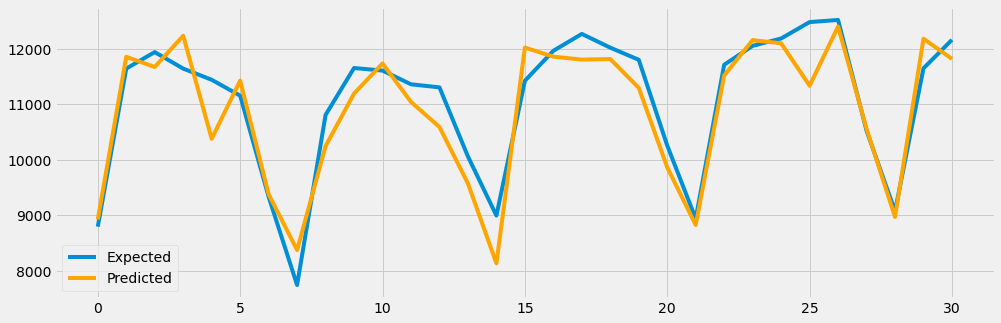

In [59]:
# plot expected vs predicted
plt.plot(y, label = 'Expected')
plt.plot(yhat, label = 'Predicted', color = 'orange')
plt.legend()
plt.show()

In [80]:
measures = get_measures(pd.Series(yhat), pd.Series(y))
df_measures = pd.DataFrame([measures])
df_measures

,erro,mae,mse,rmse,mape,smape
0,7.073865e+06,380.379067,228189.191854,477.691524,0.034833,3.534049


# FORECAST

### SKTIME - SEQUENTIAL

In [9]:
from sktime.forecasting.compose import make_reduction
df = load_data()
df.interpolate(method = "linear", inplace = True)
df_sk = df.asfreq('D')
n_test = 15
X, y = train_test_split(df_sk, n_test)
X.tail()

,load_mwmed
date,
2022-05-12,11361.001881
2022-05-13,11305.707062
2022-05-14,10060.549787
2022-05-15,8994.856748
2022-05-16,11424.087542


In [10]:
regressor = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=1000)
forecaster = make_reduction(regressor, window_length=60, strategy="recursive")
forecaster.fit(X)   # fit 
predictions = forecaster.predict(fh = [x for x in range(1,n_test + 1)]) 

c:\Users\user\anaconda3\lib\site-packages\sktime\utils\datetime.py:108: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  if not hasattr(x, "freq") or x.freq is None:
c:\Users\user\anaconda3\lib\site-packages\sktime\utils\datetime.py:110: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  by *= x.freq
c:\Users\user\anaconda3\lib\site-packages\sktime\forecasting\base\_fh.py:565: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  cutoff = _coerce_to_period(cutoff, freq=cutoff.freqstr)


In [11]:
measures = get_measures(predictions.load_mwmed, y.load_mwmed)
df_measures = pd.DataFrame([measures])
df_measures

,erro,mae,mse,rmse,mape,smape
0,7.115838e+06,621.977032,474389.198823,688.759173,0.054896,5.68278


### DIRECT

In [35]:
def multi_step_forecast(data, lag, n):
    n_test = outs = n
    data = series_to_supervised(values, n_in = lag, n_out = outs, dropnan=False)
    train, test = train_test_split(data, n_test)
    train.dropna(inplace = True)
    response_vars = data.columns[-(outs):]
    predictions = list()
    for h, response in enumerate(response_vars):
        cols = [x for x in data.columns[:lag]]
        cols.append(response)
        data_ = train[cols]
        nrows = data_.shape[0]
        data_ = data_.iloc[:nrows-h, :] 
        data_X, data_y = data_.iloc[:, :-1].to_numpy(), data_.iloc[:, -1].to_numpy() # para XGBoost não dar erro, precisa transformar em nparray
        model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=1000)
        model.fit(data_X, data_y)
        testX, testy = test.reset_index(drop=True).loc[0, :"var1(t-1)"], test.reset_index(drop=True).loc[0, response]
        pred = model.predict([testX])[0]
        print(f"Predicting {response}\n    > expected: {testy}, predicted: {pred}")
        predictions.append(pred)
    measures = get_measures(pd.Series(predictions), test["var1(t)"])
    df_measures = pd.DataFrame([measures])
    return predictions, df_measures, test

df = load_data()
df.interpolate(method = "linear", inplace = True)
values = df.values.tolist()

In [36]:
lags = 60
h = 15
pred, measures, test = multi_step_forecast(values, lags, h)
print(measures)

C:\Users\user\AppData\Local\Temp\ipykernel_80\514937903.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.dropna(inplace = True)


Predicting var1(t)
    > expected: 11964.909375, predicted: 11950.3125
Predicting var1(t+1)
    > expected: 12269.051375, predicted: 11380.8056640625
Predicting var1(t+2)
    > expected: 12021.41545833, predicted: 11531.4697265625
Predicting var1(t+3)
    > expected: 11802.52645833, predicted: 11997.3369140625
Predicting var1(t+4)
    > expected: 10256.970375, predicted: 10054.9375
Predicting var1(t+5)
    > expected: 8938.579125, predicted: 8180.8134765625
Predicting var1(t+6)
    > expected: 11713.10433333, predicted: 10775.37890625
Predicting var1(t+7)
    > expected: 12054.19504167, predicted: 11006.8037109375
Predicting var1(t+8)
    > expected: 12186.721375, predicted: 11283.6005859375
Predicting var1(t+9)
    > expected: 12482.52370833, predicted: 11736.7841796875
Predicting var1(t+10)
    > expected: 12520.80383333, predicted: 10637.490234375
Predicting var1(t+11)
    > expected: 10525.490875, predicted: 10026.642578125
Predicting var1(t+12)
    > expected: 9074.21125, predicte